<a href="https://colab.research.google.com/github/sangeetsaurabh/tweet_sentiment_extraction/blob/master/training_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is being created to understand how the selected text varies across differnt types of tweets.

In [1]:
import pandas as pd
import re

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import TranslationDataset
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import spacy
import numpy as np

import random
import math
import time

import warnings
warnings.filterwarnings('ignore')

In [2]:
### Since I am using Google Collab, loading my drive for input/output of files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_folder = "/content/drive/My Drive/tweet-sentiment-extraction/data"
tmp_folder = '/tmp'

In [4]:
### Setting the column width such that data can be seen without being truncated
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

### Copying the train and test data set
train_data = pd.read_csv(data_folder+ "/train.csv")
test_data = pd.read_csv(data_folder+ "/test.csv")

In [5]:
### Removing rows with null value
train_data = train_data[train_data.text == train_data.text]
test_data = test_data[test_data.text == test_data.text]

In [6]:
test_data.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


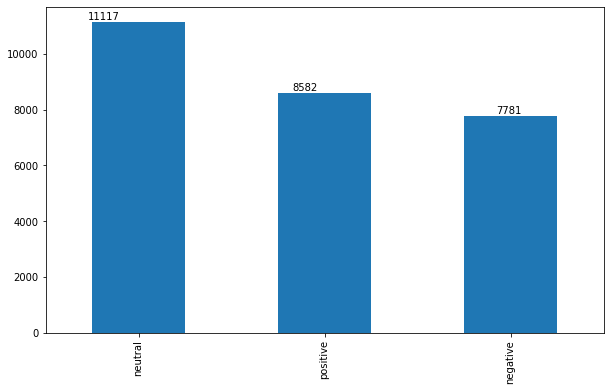

In [27]:
ax = train_data.sentiment.value_counts().plot.bar(figsize=(10,6))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()*1.1, p.get_height() * 1.01))

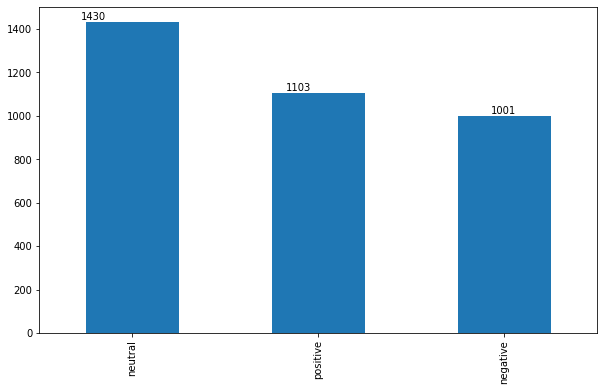

In [28]:
ax = test_data.sentiment.value_counts().plot.bar(figsize=(10,6))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()*1.1, p.get_height() * 1.01))

It appers that both train and test data has similar type of distribution. Neutral, Positive and Negative are distributed in similar ratios.

Now, let's see if there is a difference in phrase selection among these dataset.

In [31]:
### strip spaces in front and back of the text
train_data["text_len"] = train_data["text"].str.strip()
train_data["sel_text_len"] = train_data["selected_text"].str.strip()

#### Calculate the length of the text and selected text
train_data["text_len"] = train_data["text_len"].str.len()
train_data["sel_text_len"] = train_data["sel_text_len"].str.len()

In [32]:
train_data.head()

,textID,text,selected_text,sentiment,text_len,sel_text_len
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,35
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,45,8
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,74,13


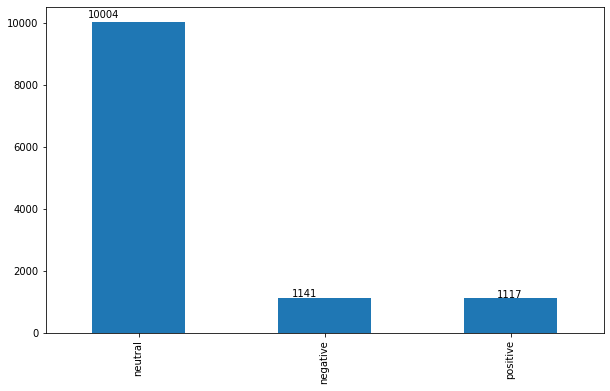

In [56]:
ax = train_data[train_data.text_len == train_data.sel_text_len]["sentiment"].value_counts().plot.bar(figsize=(10,6))
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()*1.1, p.get_height() * 1.015))

In [37]:
pd.DataFrame(, train_data[train_data.text_len == train_data.sel_text_len]["sentiment"].value_counts())

,sentiment
sentiment,
10004,NaN
1141,NaN
1117,NaN


In [39]:
train_data.sentiment.value_counts().reset_index()

,index,sentiment
0,neutral,11117
1,positive,8582
2,negative,7781


#### Visualize to see how many rows by emotion has the same selected text

In [53]:
train_counts = pd.concat([train_data.sentiment.value_counts(),train_data[train_data.text_len == train_data.sel_text_len]["sentiment"].value_counts()],axis=1)
train_counts.columns = ["total_count","row_with_same_value"]
train_counts

,total_count,row_with_same_value
neutral,11117,10004
positive,8582,1117
negative,7781,1141


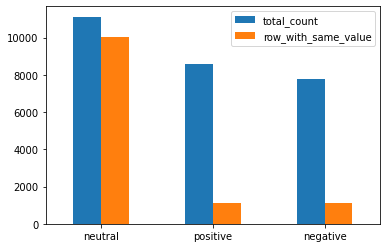

In [55]:
ax = train_counts.plot.bar(rot=0,fig=(10,6))

In [62]:
train_counts["same_%"] = (train_counts["row_with_same_value"]/train_counts["total_count"]).round(2)
train_counts

,total_count,row_with_same_value,same_%
neutral,11117,10004,0.90
positive,8582,1117,0.13
negative,7781,1141,0.15


So for neutral tweets, 90% of the selected text has the same value as the original tweet.

It will be a good idea to do first submission with selected text same as orignial tweet. That will be a good baseline.

#### What will be the score on train if tweets are submitted as is?

Jaccard testing

In [69]:
def jaccard(str1, str2): 
    a = set(str1.lower().split())
    #print(a)
    b = set(str2.lower().split())
    #print(b)
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [70]:
def calc_jacard(row):
  return jaccard(row["text"],row["selected_text"])

In [72]:
train_data["jaccard_score"] = train_data.apply(calc_jacard,axis=1)
train_data.head()

,textID,text,selected_text,sentiment,text_len,sel_text_len,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,35,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,45,8,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,74,13,0.214286


In [75]:
round(train_data.jaccard_score.mean(),2)

0.59

If text is submitted as is, we will get a score of 0.59. 

#### Analyze the size of selected text across different emotions

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1f02639b0>,
      dtype=object)

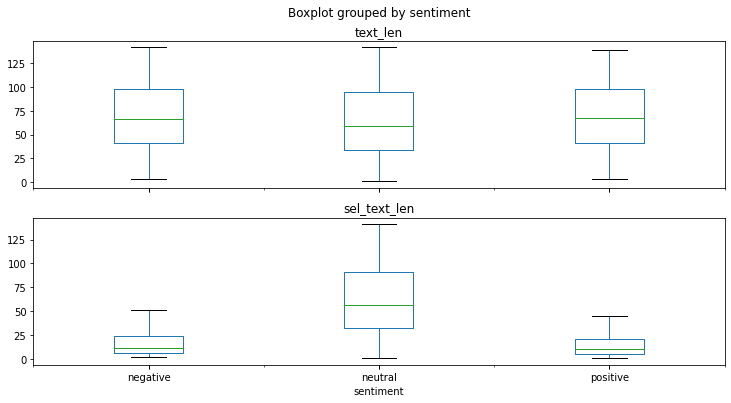

In [91]:
train_data[["sentiment","text_len","sel_text_len"]].boxplot(by="sentiment",column=["text_len","sel_text_len"], showfliers=False,grid=False,layout=(2, 1),figsize=(12,6))

In above box plot, top chart shows the lenght of the original tweet. Bottom chart shows the length of the selected text.

When the emotion is neutral, selected length is mostly the same. In case of positive or negative, selected text length is much smaller.

#### Let's do the same analysis using number of words

In [92]:
train_data.head()

,textID,text,selected_text,sentiment,text_len,sel_text_len,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,35,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,45,8,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,74,13,0.214286


In [101]:
### Calculate the number of words in text and selected text fields
train_data["text_num_of_words"] =train_data["text"].str.split().apply(len)
train_data["sel_text_num_of_words"] =train_data["selected_text"].str.split().apply(len)
train_data.head()

,textID,text,selected_text,sentiment,text_len,sel_text_len,jaccard_score,text_num_of_words,sel_text_num_of_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,35,35,1.000000,7,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,45,8,0.200000,10,2
2,088c60f138,my boss is bullying me...,bullying me,negative,25,11,0.166667,5,2
3,9642c003ef,what interview! leave me alone,leave me alone,negative,30,14,0.600000,5,3
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,74,13,0.214286,14,3


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1eb149780>,
      dtype=object)

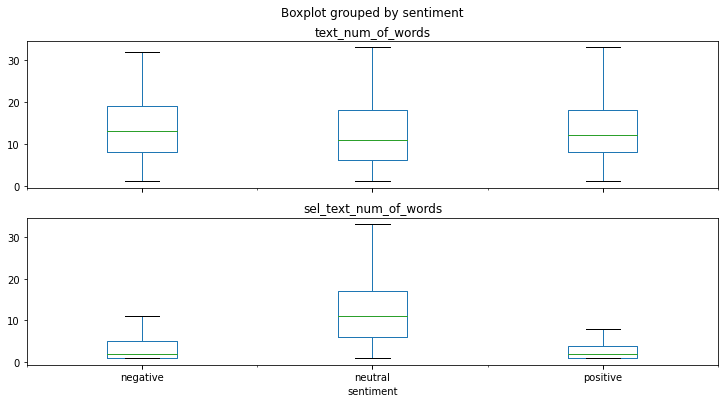

In [102]:
train_data[["sentiment","text_num_of_words","sel_text_num_of_words"]].boxplot(by="sentiment",column=["text_num_of_words","sel_text_num_of_words"], showfliers=False,grid=False,layout=(2, 1),figsize=(12,6))

Clearly number of words selected with positive and negative are very less.